<center><h1> Introduction to Audio Classification with Deep Neural Networks </h1></center>

# Abstract

### Purpose 
This notebook serves as an introduction to working with audio data for classification problems; it is meant as a learning resource rather than a demonstration of the state-of-the-art. The techniques mentioned in this notebook apply not only to classification problems, but to regression problems and problems dealing with other types of input data as well. I focus particularly on feature engineering techniques for audio data and provide an in-depth look at the logic, concepts, and properties of the Multilayer Perceptron (MLP) model, an ancestor and the origin of deep neural networks (DNNs) today. I also provide an introduction to a few key machine learning models and the logic in choosing their hyperparameters. These objectives are framed by the task of recognizing emotion from snippets of speech audio.

### Summary
Data cleansing and feature engineering comprise the most crucial aspect of preparing machine and deep learning models alike and is often the difference between success and failure. We can drastically improve the performance of a model with proper attention paid to feature engineering. This stands for input data which is already useable for predictions; even such data can be transformed in myriad ways to improve predictive performance. For features to be useful in classification they must encompass sufficient variance between different classes. We can further improve the performance of our models by understanding the influence of and precisely tuning their hyperparameters, for which there are algorithmic aids such as Grid Search. 

Network architecture is a critical factor in determining the computational complexity of DNNs; often, however, simpler models with just one hidden layer perform better than more complicated models. The importance of proper model evaluation cannot be overstressed: training data should be used strictly for training a model, validation data strictly for tuning a model, and test data strictly to evaluate a model once it is tuned - a model should never be tuned to perform better on test data. To this end, K-Fold Cross Validation is a staple tool. Finally, the Random Forest ensemble model makes a robust benchmark model suitable to less-than-clean data with unkown distribution, especially when strapped for time and wishing to evaluate the useability of features extracted from a dataset. 

### Conclusions
Classic machine learning models such as Support Vector Machines (SVM), k Nearest Neighbours (kNN), and Random Forests have distinct advantages to deep neural networks in many tasks but do not match the performance of even the simplest deep neural network in the task of audio classification. The Multilayer Perceptron (MLP) model is the simplest form of DNN suited to classification tasks, provides decent off-the-shelf performance, and can be precisely tuned to be accurate and relatively quick to train. 

The MLP provides appreciable accuracy on the RAVDESS dataset, but suffers from the relatively small number of training samples afforded by this dataset. Long Short Term Memory Recurrent Neural Networks (LSTM RNNs) and Convolutional Neural Networks (CNNs) are excellent DNN candidates for audio data classification: LSTM RNNs because of their excellent ability to interpret sequential data such as the audio waveform represented as a time series, and CNNs because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognition and discrimination between distinct patterns. 



<!--TABLE OF CONTENTS-->
# Table of Contents
  - [Intro: Speech Emotion Recognition on the RAVDESS dataset](#Intro:-Speech-Emotion-Recognition-on-the-RAVDESS-dataset)
  - [Machine Learning Process Overview](#Machine-Learning-Process-Overview)
  - [Feature Engineering](#Feature-Engineering)
    - [Short-Time Fourier Transform](#Short-Time-Fourier-Transform)
    - [Mel-Frequency Cepstral Coefficients](#Mel-Frequency-Cepstral-Coefficients)
    - [Mel Spectrograms and Mel-Frequency Cepstrums](#Mel-Spectrograms-and-Mel-Frequency-Cepstrums)
    - [The Chromagram](#The-Chromagram)
  - [Feature Extraction](#Feature-Extraction)
    - [Load the Dataset and Compute Features](#Load-the-Dataset-and-Compute-Features)
    - [Feature Scaling](#Feature-Scaling)
  - [Classical Machine Learning Models](#Classical-Machine-Learning-Models)
    - [Training: The 80/20 Split and Validation](#Training:-The-80/20-Split-and-Validation)
    - [Comparing Models](#Comparing-Models)
    - [The Support Vector Machine Classifier](#The-Support-Vector-Machine-Classifier)
    - [k Nearest Neighbours](#k-Nearest-Neighbours)
    - [Random Forests](#Random-Forests)
        - [OOB Score](#OOB-Score)
  - [The MLP Model for Classification](#The-MLP-Model-for-Classification)
    - [Choice of Hyperparameters](#Choice-of-Hyperparameters)
    - [Network Architecture](#Network-Architecture)
    - [Hyperparameter Optimization and Grid Search](#Hyperparameter-Optimization-and-Grid-Search)
  - [Training and Evaluating the MLP Model](#Training-and-Evaluating-the-MLP-Model)
    - [The Confusion Matrix](#The-Confusion-Matrix)
    - [Precision, Recall, F-Score](#Precision,-Recall,-F-Score)
    - [K-Fold Cross-Validation](#K-Fold-Cross-Validation)
    - [The Validation Curve: Further Tuning of Hyperparameters](#The-Validation-Curve:-Further-Tuning-of-Hyperparameters)
    - [The Learning Curve: Determining Optimal Training Set Size](#The-Learning-Curve:-Determining-Optimal-Training-Set-Size)
  - [Higher Complexity DNNs](#Higher-Complexity-DNNs)

## Intro: Speech Emotion Recognition on the RAVDESS dataset
In this notebook we explore the most common machine learning models, specifically those available off the shelf in scikit-learn. After benchmarking performance with machine learning models, we train a Multilayer Perceptron (MLP) model for classification in an attempt to recognize the emotion conveyed in a speech audio snippet. MLP classifiers are a good DNN model to start with because they are simple, flexible, and suited when inputs are assigned a label - in our case, emotion.

I'm going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University. <br>
[Details of the RAVDESS dataset](https://smartlaboratory.org/ravdess/) <br>
[Download the dataset used in this notebook](https://zenodo.org/record/1188976) <br> Scroll half-way down the page and find "Audio_Speech_Actors_01-24"<br>

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences with
a variety of emotions and intensity. We get 1440 speech files (24 actors * 60 recordings per actor). Each audio sample has been rated  by a human 10 times for emotional quality.

## Machine Learning Process Overview 
1. Feature Engineering: Choose and define the properties which our model will use to evaluate the audio files. <br>
2. Feature Extraction: Compute the features for each audio file and build a feature matrix representing all audio files. <br>
3. Model exploration: Test candidate models that make sense for the properies of the dataset
4. Training the MLP Classifier model: Choose and optimize the properties of our model on validation data - hyperparameters and architechture.  <br>
5. Evaluate our model's performance: Evaluate our model's accuracy on validation data and score it against test data which it has never seen in training.<br>
6. Explore options for improving our model: Is our dataset the right size? Is our model too complex or too simple? <br>


## Feature Engineering
Before building any sort of predictive models, we not only need data - but we need a usable representation. Enter feature engineering. 

An audio file can be represented as a time series with the dependent axis being
the amplitude of the audio waveform. The waveform of the sound file is all the information we have with which to create features to train our model. However, the shape of a waveform does not carry enough discriminating information, so we need to transform the waveform into a more useable form, pun intended. <br> 

Sometimes our input dataset _does_ have enough information to train a model to give accurate results - but even then input data should be scrutinized and transformed - this allows us to pick the best model for our features, which is usually much better and different than a model that works on our raw input data.  Proper feature engineering carries advantages not limited to 

 - **More accurate, generalizable models**
 - **Insight into model's decision-making behaviour**
 - **Flexibility in choice of models**
 - **Faster training** 

**Before feature engineering, we always cleanse our data** - which may consist of removing outliers (carefully), removing irrelevant input data according to business logic, or removing noise. For audio, data cleaning may consistent of making audio samples equal in length and padded with silence at either end. The RAVDESS dataset has done that for us, but this is a rare case. 

That being said, let's see what we're starting with by comparing the waveforms of "Happy" and "Angry" of Actor 1:

In [112]:
# Get the critical imports out of the way
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
import seaborn as sns
import tqdm
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML 
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## EDA

In [95]:
train_dist = pd.read_csv('../dataset/train.csv', index_col = 'filename')
train_dist

,emotion
filename,
18777.mp3,neutral
24041.mp3,neutral
1621.mp3,joy
28883.mp3,neutral
14918.mp3,neutral
...,...
6688.mp3,neutral
41901.wav,fear
2066.mp3,neutral


In [173]:
test_dist = pd.read_csv('../dataset/test.csv', index_col = 'filename')
test_dist

""
filename
26199.mp3
692.mp3
16821.mp3
1608.mp3
47947.wav
...
16692.mp3
29505.mp3
5807.mp3


In [176]:
test_dist.loc['26199.mp3']

Series([], Name: 26199.mp3, dtype: float64)

In [91]:
train_dist

,filename,emotion
0,18777.mp3,neutral
1,24041.mp3,neutral
2,1621.mp3,joy
3,28883.mp3,neutral
4,14918.mp3,neutral
...,...,...
5811,6688.mp3,neutral
5812,41901.wav,fear
5813,2066.mp3,neutral
5814,10825.mp3,surprise


<AxesSubplot:xlabel='emotion', ylabel='count'>

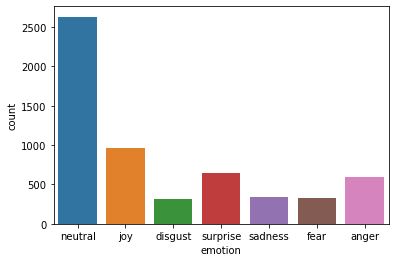

In [18]:
sns.countplot(train_dist.emotion)

Text(0.5, 1.0, 'Angry')

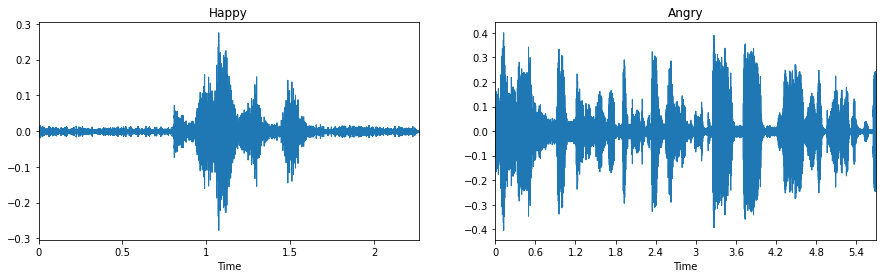

In [106]:
################# Load Happy and Angry example of Actor 1 #####################################
with soundfile.SoundFile('../dataset/wavdatatrain2/43127.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(waveform, sr=sample_rate)
    plt.title('Happy')
    
waveform, sample_rate = librosa.load('../dataset/TrainAudioFiles/0.mp3', mono = True)
plt.subplot(1, 2, 2)
librosa.display.waveplot(waveform, sr=sample_rate)
plt.title('Angry')

# with soundfile.SoundFile('.\\RAVDESS dataset\\actor_01\\03-01-05-02-01-02-01.wav') as audio:
#     waveform = audio.read(dtype="float32")
#     sample_rate = audio.samplerate
#     plt.subplot(1, 2, 2)
#     librosa.display.waveplot(waveform, sr=sample_rate)
#     plt.title('Angry')

Alright, there's a visible difference - but not enough to classify by emotion. Take my word for it. Try it if you like. However, [raw waveforms can be used](https://arxiv.org/abs/1712.00866) for certain other audio classification tasks with the right network. 

So, where do we get features suitable for emotion classification?
### Short-Time Fourier Transform
The lowest-hanging fruit in time series signal processing is, of course, the Fourier Transform.
Specifically, we'll use the Short-Time Fourier Transform (STFT) which will cut our audio waveform into short, overlapping equal length segments and
take the Fourier transform of each segment individually to produce multiple power spectrograms, identifying resonant frequencies present in our audio file. The major advantage of STFT is better resolution of _changes_ in the audio signal w.r.t. time. <br>
<img src="img/stft.png" width=600 height=600 />

Let's start visualizing our features to get a better handle on them. <br>
Load a sample audio file from our dataset - each audio file is 3 seconds in length.

In [61]:
with soundfile.SoundFile('../dataset/wavdatatrain2/1.wav') as audio:
    happy_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile('../dataset/wavdatatrain2/1.wav') as audio:
    angry_waveform = audio.read(dtype="float32")
    # same sample rate

In [74]:
happy_waveform, sr = librosa.load('../dataset/wavdatatrain2/1.wav', mono=True)

angry_waveform, sr2 = librosa.load('../dataset/wavdatatrain2/0.wav', mono = True)

In [76]:
angry_waveform.shape

(125464,)

##### Visualize the combination of power spectrograms output by STFT w.r.t time:

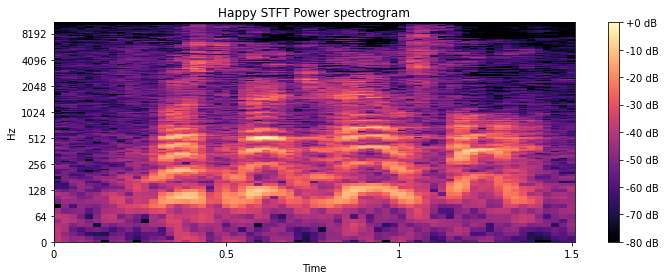

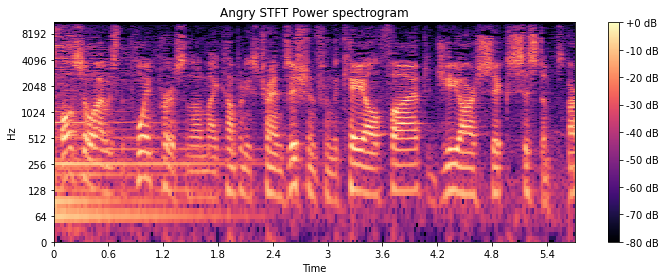

In [77]:
stft_spectrum_matrix = librosa.stft(happy_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Happy STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(angry_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

We're getting somewhere, but we're going to have to go further. **We operate under the assumption that features whose interclass differences we can visualize will be good candidates on which to train a neural network.** Looks like further transformations on the STFT will yield good features. Since we have a 3 second audio file, STFT spectrograms for these audio samples combine to show the change in frequencies across a 3 second window.

### Mel-Frequency Cepstral Coefficients
We're going to build on the STFT by using the Mel Frequency Cepstral Coefficients (MFCCs) as a feature.
In brief, MFCC is a mathematical method which transforms the power spectrum of an audio signal to a small number of coefficients representing power of the audio signal in a frequency region (a region of pitch) taken w.r.t. time. 
<br><br>
In other words, MFC coefficients give us an idea of the changing pitch of an audio signal. 

To understand our major feature a little better, we should at least have a vague idea of the math behind it.
MFCC at its core uses STFT to produce audio power spectrums. We then apply triangular, overlapping window functions to the power spectrograms and take the sum of energy in each window which is essentialy a frequency bin. To determine the number and position of window functions, and width of each frequency bin, we map the frequencies of our audio's power spectrograms to the [Mel scale](https://en.wikipedia.org/wiki/Mel_scale), a nonlinear pitch scale representing the perceived pitch in 'mels' of an audio signal w.r.t. its frequency. The motivation for the mel scale is to account for the way human hearing perceives pitch based on frequency ratios rather than absolute differences in frequencies. The window functions/frequency bins we applied in this step are called mel filterbanks.

Now we can take the log of the sum of power in each mel frequency filterbank. Taking the log power of an audio spectrogram produces a cepstrum - more on this a little later. 

###### The Discrete Cosine Transform
Finally, we apply the discrete cosine transform [(DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) to the log of power in each filterbank. The DCT carries distinguished advantages: Because triangular window functions overlap, the mel filterbank energies are correlated with each other; DCT decorellates the signals; DCT produces coefficients such that usually only the top few coefficients are necessary to represent a signal with fair accuracy, i.e. a compressed representation. **In this way, DCT is quite similar to PCA** - one key difference being that DCT has an absolute definition while PCA is only defined w.r.t. a dataset. For this reason (and a couple others) DCT sees a _huge_ range of applicability: image and audio data compression (read: internet, wireless tech, medicine) and cryptography are most notable. Our MFC coefficients are then the amplitudes of each DCT-transformed log filterbank power, taken w.r.t. time. 

Another way to think about MFCC is as a deconvolution method to identify periodic, or resonant structures within an audio signal's frequency space. We can visualize our MFC coefficients by plotting the coefficients provided by each mel filterbank against time. 

I've found for this task that 40 filterbanks producing 40 coefficients provide the best accuracy and quick computation. 

###### Visualize our sample's MFC coefficients w.r.t time:

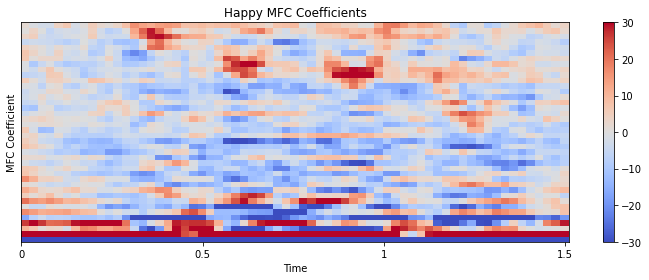

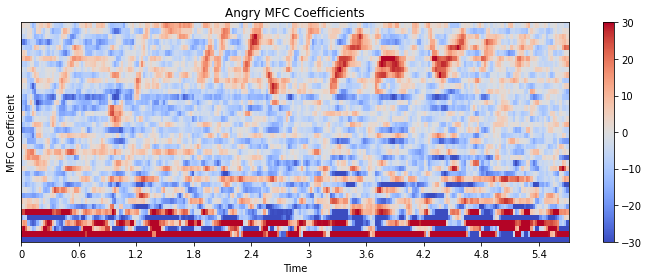

In [78]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=happy_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Happy MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Angry MFC Coefficients')
plt.tight_layout()

**Positive MFCCs correspond to low-frequency regions of the cepstrum, and negative MFFCs to high-frequency.**

**We see the Angry voice has a much greater proportion of positive MFFCs, corresponding to a lower voice pitch compared to the Happy voice. Makes sense - a happy voice carries a lighter tone and a higher pitch.**

##### Quick MFCC Derivation
1. Take the square of magnitudes in spectrograms produced by STFT to produce audio power spectrograms for short overlapping frames of the audio signal, <br>
2. Apply a mel-scale-based transformation, mel filterbanks (triangular window functions) to each STFT power spectrogram and sum the power in each filterbank <br>
3. Take the log of each filterbank power <br>
4. Take the discrete cosine transform of each log power in each STFT frame, giving us the MFC coefficients - our measure of power at various mel frequencies, corresponding to audible pitch. <br>

Wikipedia has a pretty straight-forward explanation of [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).



### Mel Spectrograms and Mel-Frequency Cepstrums
In deriving our MFCCs, we have also produced an additional feature we can make use of. 
When we mapped the frequencies of a power spectrogram to the mel scale, we produced a Mel Frequency Spectrogram - 
a simple analog of the power spectrogram with the frequency scale in mels. 
We're going to use the Mel Specotrgrogram as a feature of its own. 

##### Visualize our sample's Mel spectrogram w.r.t time:

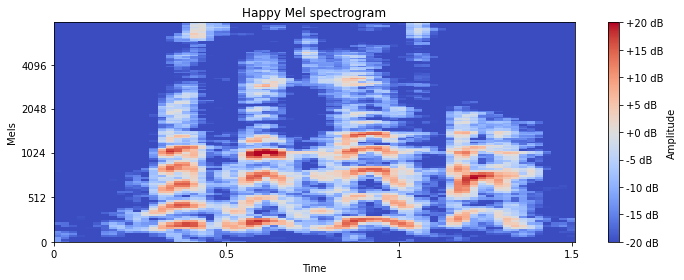

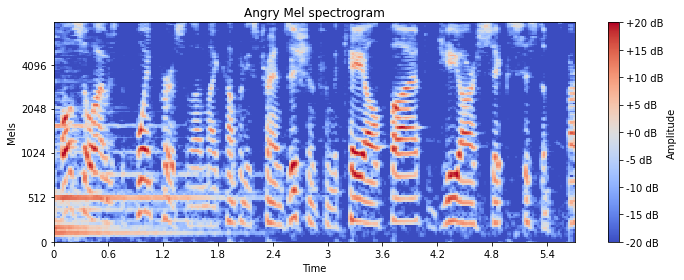

In [79]:
melspectrogram = librosa.feature.melspectrogram(y=happy_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Happy Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Angry Mel spectrogram')
plt.tight_layout()

**The Angry voice produces sharper transitions between mel frequency peaks compared to the Happy voice, which has smoother pitch transitions. That makes intuitive sense - an Angry voice has sharp transitions while a happy voice is more steady and pleasing to the ears. Mel spectrograms will make another good feature.**

What about the cepstrum? When we took the log of the spectral amplitudes in a Mel-scaled power spectrogram, we could have plotted that result as a time series and produced what is known as a 'mel-frequency cepstrum', now in the 'quefrency' domain, so confusingly named because we have applied a transformation to an audio signal in its frequency domain, but have plotted it as a time series - not quite in the frequency domain, not quite in the time domain. In the cepstrum, we observe a peak wherever there is a periodic element in the original audio signal. We've actually already used the the mel-frequency cepstrum (MFC) as a feature, since that is precisely the source of our MFC coefficients. Again, Wikipedia has a fairly palatable explanation of the [cepstrum](https://en.wikipedia.org/wiki/Cepstrum). 

Below is an excellent visualization of the transformations between waveform, spectrogram, mel spectrogram, and MFCCs plotted as time series.
The vertical frame in each graph represents a single STFT frame.<br>
<img src="img/mfcc.gif" width=800 height=600/> <br>


### The Chromagram
To extract an additional feature, we're going to build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal w.r.t. time, mapping audio signal to a pitch class.
Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes).
Again, wikipedia has a short and sweet [explanation](https://en.wikipedia.org/wiki/Chroma_feature). Below is a visualization of the relation between an audio waveform and its chromagram:

<img src="img/chromagram.png" width=500 height=500 />

##### Visualize the chromagram for our sample audio:

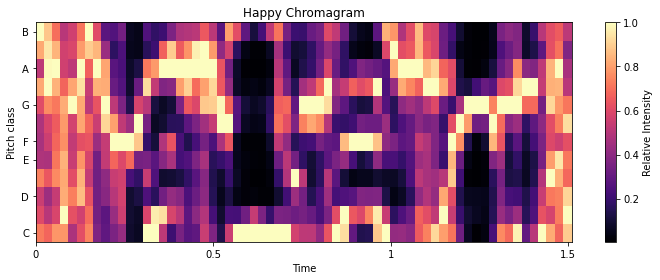

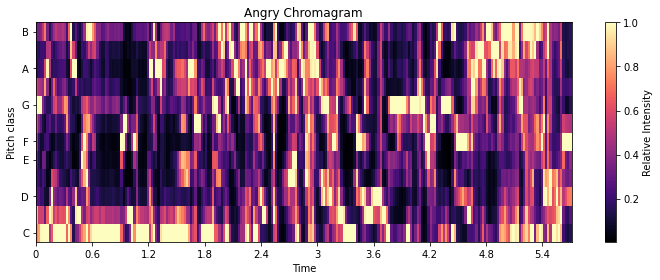

In [80]:
chromagram = librosa.feature.chroma_stft(y=happy_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Happy Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Angry Chromagram')
plt.tight_layout()

**The pitch distribution of the Angry voice has a much lower dispersion compared to the Happy voice, whose pitch has a higher dispersion at any point in time. This makes intuitive sense considering the tone of an angry voice is more intense and "snappy" compared to a happy voice, which is smoother to the ears - here's a good explanation as to why. This should make a good feature.**

## Feature Extraction
We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction.
Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. 
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between samples. <br>

Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40 which I found to work well

In [81]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to
stack them horizontally to create a single feature array.

In [87]:
def get_features(file):
    # load an individual soundfile
    waveform, sample_rate = librosa.load(file, mono=True)
    chromagram = feature_chromagram(waveform, sample_rate)
    melspectrogram = feature_melspectrogram(waveform, sample_rate)
    mfc_coefficients = feature_mfcc(waveform, sample_rate)

    feature_matrix=np.array([])
    # use np.hstack to stack our feature arrays horizontally to create a feature matrix
    feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

    return feature_matrix

### Load the Dataset and Compute Features
We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample.
Each file is labelled with 7 numbers delimited by a "-".
Most of the numbers describe metadata about the audio samples such as their format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.

The third and fourth numbers pertain to the emotional quality of each sample. The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:

neutral     2630
joy          967
surprise     640
anger        596
sadness      344
fear         328
disgust      311

In [8]:
#Emotions in the RAVDESS dataset
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sadness',
  '05':'anger',
  '06':'fear',
  '07':'disgust',
  '08':'surprise'
}

Finally, let's load our entire dataset and compute the features of each audio file:

In [129]:
train_dist.loc['18777.mp3'].emotion

'neutral'

In [136]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in tqdm.tqdm_notebook(glob.glob("../dataset/TrainAudioFiles/*")):
        file_name=os.path.basename(file)
        emotion= train_dist.loc[file_name].emotion
        features = get_features(file)
        X.append(features)
        y.append(emotion)a
        count += 1
        # '\r' + end='' results in printing over same line
        #print('\r' + f' Processed {count} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

Compute the feature matrix and read the emotion labels for the entire dataset.
Note that our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent variable), usually denoted y, is named 'emotions'.

In [137]:
features, emotions = load_data()

  0%|          | 0/5816 [00:00<?, ?it/s]

In [177]:
def load_test_data():
    X = []
    file_list = []
    count = 0
    for file in tqdm.notebook.tqdm(glob.glob("../dataset/TestAudioFiles/*")):
        file_name=os.path.basename(file)
#         emotion= train_dist.loc[file_name].emotion
        features = get_features(file)
        X.append(features)
        file_list.append(file_name)
        count += 1
        # '\r' + end='' results in printing over same line
        #print('\r' + f' Processed {count} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), file_list

In [178]:
test_features, test_files = load_test_data()

  0%|          | 0/2492 [00:00<?, ?it/s]

In [184]:
np.save('../dataset/features_test/features1test.npy', test_features)
np.save('../dataset/features_test/testfiles1.npy', np.array(test_files))

In [157]:
np.save('../dataset/features_train/features1.npy', features)
np.save('../dataset/features_train/emotions1.npy', emotions)

In [159]:
temp1 = np.load('../dataset/features_train/emotions1.npy')
temp1.shape

(5816,)

Let's see what the features we extracted look like:

In [139]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
features_df


Audio samples represented: 5816
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.828802,0.776572,0.728830,0.690291,0.648963,0.616631,0.604438,0.659653,0.724184,0.684382,...,-4.842699,-2.248137,-7.942684,-3.471039,-6.954829,-1.879871,-5.705071,-0.982469,-4.394181,-5.872784
1,0.475188,0.492044,0.481400,0.493211,0.583935,0.561002,0.601978,0.586572,0.562161,0.518574,...,-2.413347,1.818822,-2.962267,4.307155,-0.769376,2.737145,0.155682,-0.025112,-3.109703,0.663490
2,0.641984,0.637232,0.623376,0.585070,0.553275,0.630166,0.611519,0.645227,0.653782,0.687789,...,-5.936871,-5.303837,-3.399852,-0.766234,0.771640,4.694548,1.771403,1.897175,-2.931957,3.825536
3,0.615009,0.662403,0.596927,0.618235,0.826052,0.720992,0.504286,0.487703,0.604592,0.865283,...,1.742306,8.469556,-0.422239,-2.008815,-9.860036,-2.269429,-1.560695,0.849330,-5.631278,-2.229236
4,0.649535,0.611775,0.571774,0.561810,0.607842,0.625037,0.651730,0.602507,0.668354,0.706254,...,1.984264,-0.598174,4.707690,-1.210861,3.258099,-0.019830,1.330393,1.170374,3.326979,0.643368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,0.530357,0.473381,0.507838,0.483539,0.588861,0.584256,0.533496,0.448057,0.426545,0.488408,...,-0.656757,1.467922,-4.114019,-1.540944,-3.405411,2.991051,0.057117,0.222478,-1.731786,-2.229682
5812,0.672894,0.658625,0.651280,0.678092,0.847649,0.832867,0.637806,0.572252,0.526195,0.533103,...,-10.142788,-6.331141,-7.482287,-4.258958,-7.251288,-5.798922,-2.232540,-1.045433,-0.206167,2.654501
5813,0.648151,0.568789,0.565125,0.593877,0.535578,0.554290,0.532680,0.520057,0.636535,0.646685,...,-2.651855,4.073972,1.298764,6.440004,2.601233,2.274999,-3.289468,-1.662600,-4.478760,1.935302
5814,0.669128,0.618862,0.544211,0.583225,0.610410,0.606669,0.595847,0.549882,0.578460,0.567214,...,-7.288116,2.313541,-4.404861,-0.636456,-2.829343,1.354569,-3.206423,2.756523,-2.103667,0.738310


We have a matrix of dim 1440 x 180. Looks good - 1440 audio samples, one per row, with a series of
180 numerical features for each sample. 

**Each of the 1440 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**

Let's see the class balance of our dataset:

**Great, the classes appear to be balanced. That makes the task easier.** All emotions _except_ the neutral class have a "strong" intensity so there are half as many neutral samples. That might have an impact.

### Feature Scaling
To properly train most machine learning models on _most_ datasets, we first need to scale our features. **This is crucial for models which compute distances between data, and especially critical for DNNs**: If there is a difference in the variance of features simply because of their possible range of values, then a model will learn that the features with the greatest variance are the most important. However, **differences in the variance of unscaled features belonging to different and unknown distributions is an inappropriate measure of importance.** Let's check our features' properties:

In [142]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}') 

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')
    
print_features(features_df)

12 Chromagram features:           min = 0.143,     max = 1.000,     mean = 0.624,     deviation = 0.091

128 Mel Spectrogram features:     min = 0.000,     max = 445.566,     mean = 0.278,     deviation = 1.799

40 MFCC features:                 min = -656.802,    max = 167.265,    mean = -7.157,    deviation = 54.627


**There's an obvious imbalance in the variance our features; Our features indeed belong to very different distributions:** our MFC coefficients' deviation is greater than the other features by orders of magnitude. That does not mean MFC coefficients are the most important feature, but rather it is a property of the way they are computed.  We will certainly need to scale this feature set.

We have the choice of sklearn's StandardScaler and MinMaxScaler. Standard scaling subtracts the mean of each feature and divides it by the standard deviation of that feature, producing features with mean at zero and unit variance - that is, a variance and standard deviation of 1. Min-Max scaling transforms each feature to be within a bounded interval that we specify. 

In practice, **MinMax scaling is especially useful when we know our features should be in a bounded interval**, such as pixel values in [0,255], while **standard scaling is perhaps more practical for features with unknown distributions** because centering the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights, i.e. the model is less sensitive to outliers. 

We'll create MinMax scaled features as well so we can give them a try later on to confirm that standard scaling is better in the absence of knowledge on the appropriate distribution for a dataset's features.

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features 
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

Make sure our features are properly scaled:

In [144]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -5.345,     max = 4.413,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.520,     max = 69.511,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -6.496,    max = 9.932,    mean = -0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.551,     deviation = 0.118

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.010,     deviation = 0.032

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.434,    deviation = 0.122


Perfect. Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling - a default when we don't specify values. We can now move on to building predictive models for these features.

## Classical Machine Learning Models

**It's always a good idea to take a little time to check if a simpler model makes sense for a particular data set before jumping to deep neural networks.** 

The time to fit classic machine learning models is often limited by the size of a dataset. The Support vector machine (SVM) is a prime example because it is limited by its quadratic complexity w.r.t. # of samples. In contrast, **fitting even the simplest DNN - an MLP - carries a significantly higher time complexity:** While an MLP is linear w.r.t. samples, it is limited by its exponential time complexity w.r.t. number of hidden layers due to its use of backpropogation. In the case of 1 hidden layer - which is often enough as we will see - the MLP competes with some classic models for time complexity. 

Besides that, a decent argument can be made to use a classic machine learning method due to the small size of our dataset; Some of the most robust models such as Support vector (machine) classifiers **(SVC) and k-Nearest-Neighbour classifiers (kNN) are particularly suited to smaller datasets and fall apart with huge datasets.**


### Training: The 80/20 Split and Validation
In order to compare models, we'll have to evaluate their performance. The simplest method to do so is to train a model on a portion of our dataset and test it on the remainder. We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

More accurately, the proper modality for training and scoring a model is to 
1. Fit/train our model on a _training_ set, 
2. Evaluate the model on a _validation_ set to tune the hyperparameters for better performance,
3. Finally score our model's true performance - its **generalizability** - against a _test_ set, aka the hold-out set. 
4. Repeat from 2. **Do not tune the model to score well on the test set**. 

Different set ratios are used in this approach - a usual example is 60/20/20 train/validation/test. 

For simplicity, we're going to start with an 80/20 train/test split. The model will be trained on all the training data, and we will check its performance on the test data. Define unscaled and scaled training and test sets:

In [146]:
############# Unscaled test/train set #############
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

### Comparing Models
We'll try each off-the-shelf machine learning model from sklearn and pick a few to explore, since these models will train near instantly on this dataset.

In [149]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    print("Score of {} : {}".format(model_name, score))
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

Score of KNeighborsClassifier : 0.45618556701030927
Score of SVC : 0.5017182130584192
Score of SVC : 0.5120274914089347
Score of DecisionTreeClassifier : 0.44673539518900346
Score of RandomForestClassifier : 0.5661512027491409
Score of AdaBoostClassifier : 0.4896907216494845
Score of GaussianNB : 0.4639175257731959
Score of QuadraticDiscriminantAnalysis : 0.36254295532646047


,Classifier,Accuracy Score
4,RandomForestClassifier,56.62%
2,SVC RBF kernel,51.20%
1,SVC,50.17%
5,AdaBoostClassifier,48.97%
6,GaussianNB,46.39%
0,KNeighborsClassifier,45.62%
3,DecisionTreeClassifier,44.67%
7,QuadraticDiscriminantAnalysis,36.25%


Let's pick the top three - Random Forests, SVC, and kNN - and take a closer look at each of them.

### The Support Vector Machine Classifier
 
We'll go in chronological order. First is the support vector machine classifier (SVC) - a model from the 60s. SVMs are models quick to train for this task and best suited to small datasets due to its quadratic time complexity w.r.t. size of the training dataset (# of training samples). This is also the reason it breaks down with larger datasets since it becomes very expensive to train.

The idea behind SVMs on which the SVC model is based is to find a separating hyperplane - a subspace with dimension one less than that of the feature space - for points in our feature space; i.e. for a 3D space, a hyperplane is a regular plane, in 2D, a line. This idea extends to n dimensions. If points are separable by a hyperplane, they are said to be linearly separable. **Since there are infinite possible separating hyperplanes for any linearly separable feature space, an SVM computes which points are closest to each such hyperplane and uses them to construct a _support vector_. The SVM picks the hyperplane which maximizes the distance - _margin_ - to each support vector.** In this way, we maximize the separating ability of the chosen hyperplane. 

The core of SVMs is the kernel. We could map all new points from our input space, where they were not separable by a hyperplane, to a higher dimension in which we have found a hyperplane to separate the points in that space. However, that would be extremely computationally expensive for data that needs to be mapped to much higher dimensions. Instead, we **compute the hyperplane in the higher dimension on our training data and map the hyperplane back to the lower-dimension input space to use for classifying our data. This is the _kernel trick_, whereby the kernel (function) enables us to compute distances to new points in the input space without transforming each to the higher dimensional space - drastically reducing the computational complexity of the SVM.**

<img src="img/kernel1.png" />

A linear kernel should always be tested because **a linear kernel is much faster to train than a non-linear kernel**; however, properly tuned, a non-linear kernel often provides the best possible predictive performance. **RBF (radial basis function) is a good default to use for a non-linear kernel** and often is the best non-linear kernel because it usually provides a higher accuracy compared to other non-linear kernels at the cost of higher computational complexity. We can afford to try the RBF kernel because our dataset is small.

In [150]:
from sklearn.svm import SVC

model = SVC(
    C=10,
    gamma='auto',
    kernel='rbf',
    random_state=69
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 99.91%
SVC Model's accuracy on test set is 52.58%


Not bad at all for the relatively simple SVC model. **C is a regularization parameter inversely proportional to size of l2 penalty.** It might do well to optimize the SVC model further if we don't find a better one. As it stands, we are looking for considerably higher performance in this task. 

### k Nearest Neighbours 

k Nearest Neighbours (kNN) is next in line, a tried-and-true machine learning method from the 70s. kNN makes a lot of intuitive sense: imagine plotting points on a graph and drawing gates around points that look like they belong to the same group. That's what it is - we **plot our training samples' features and compare a test sample's features' distance to all those points; then just take the _k_ closest points to the test sample and pick the most frequent label/class.** That's it.

kNN is a great starting point for multiclass problems with small datasets, although on large dadtasets less reliable and extremely memory hungry (it stores all training sample points). kNN is also useful in that it makes **no assumptions about the underlying distribution of the data set - so kNNs work well for both linear and non-linear data.** In the 2D example:

<img src="img/knn.png" width=400 height=400 />

In [167]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
# model = KNeighborsClassifier(
#     n_neighbors = 5,
#     weights = 'distance',
#     algorithm = 'brute',
#     leaf_size = '30',
#     n_jobs=4
# )

# model.fit(X_train, y_train)

# print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
# print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 60.53%
Default kNN Model's accuracy on test set is 43.64%



**The brute-force algorithm computes distances between all pairs of points in the training set; works especially well for small datasets** but wildly inefficient w.r.t. increasing samples and feature space dimension. Not bad for 2 minutes of work, but still not suitable for this task.

### Random Forests 
Finally, and before resorting to deep learning methods, let's try a Random Forest -  a model from the 21st century (2001). **We train many distinct decision trees which are essentially directed acyclic graphs (DAGs), somewhat similar to a flow chart. The collection of (decision) trees makes up our Random Forest.** 

At each node of the tree we have a function (a rule) that evaluates whether the features of samples input to that node belong to one class or another. Each branch of the tree (or, edge of the graph) defines one of two possible results from a node, and each leaf is one of two decisions made by its parent node. **Each tree in the forest evaluates a random subset of the training samples' features and has a rule at each level of the tree that classifies based on these random features - hence, _Random_ Forest. This random selection of features makes Random Forests robust to outliers**, as such features will have less of an impact in the scope of the entire forest, most of whose trees operate on the "real" features.

**Random Forests are excellent models to use as a benchmark due to their low time complexity to train and because it is an ensemble method, their robustness to unknown distributions and outliers in the dataset,** meaning Random Forests require relatively little exploratory analysis in both the data and training the model to get an idea of their performance in a task. 

<img src="img/randomforest.png" width=500 height=500 />

In [152]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 99.91%
Default Random Forest Model's accuracy on test set is 56.79%

Random Forest Model's accuracy on training set is 99.91%
Random Forest Model's accuracy on test set is 57.04%


Not bad for zero effort put into the default model. **Random Forests make a good benchmark model**, especially when strapped for time. For comparison, SVC with default hyperparameters spits out a measly 30% accuracy for this task.

**_Max features_ defines size of random feature subset decided upon at each node; sqrt(#features) is a good default for classification. Max features must be set to have a 'real' Random Forest.** 

**_Gini_ and _Entropy_ are functions computing quality of classified samples within each node; they almost always provide similar performance but Entropy is more suited to classification while Gini is better for continuous variables.** 

**An ensemble of high variance, low bias decision trees _generally_ combine to create a low variance, low bias Random Forest when properly tuned.** In this way, Random Forests are _generally_ less susceptible to overfitting, although clearly not always as demonstrated here.

#### OOB Score
OOB score is an internal model performance metric unique to Random Forests, though further on I will talk about evaluating models in more depth using K-Fold Cross Validation, a technique to get a more realistic picture of a model's performance. While we would usually apply KFold CV to the machine learnings models above, we would not necessarily do so for the Random Forest. Why? Because Random Forests internally calculate a metric known as the **Out-of-Bag Score** (OOB Score).

Each decision tree in the Random Forest trains on a slightly different set of data. Each tree's training set is obtained by **bootstrapping**: training data is randomly sampled with replacement from the input data. As such, the deviations in the original training dataset have much less of an impact on the the final prediction output by a Random Forest ensemble, which is determined by a majority vote of the predictions of each decision tree in the forest. This confers the advantage of a **reduced variance in the complete ensemble model with no trade-off in bias.**

When we combine bootstrapping with an ensemble model, we call it **bagging**. A more intuitive name for this method is **bootstrap aggregation** - aptly named based on the combination of decision trees trained on bootstrapped data. When we train a model this way, in particular a Random Forest, each decision tree is scored against its out-of-bag (OOB) samples, i.e. those which were not included in training that particular decision tree. As in K-Fold CV, we're scoring the ensemble model on a variety of validation sets. The combination of all **OOB scores** for each decision tree makes up the OOB score for the Random Forest.  

In this way, we get a sort of **"free" cross-validation out of the Random Forest.**

In [153]:
print(f'Random Forest Model\'s OOB score: {100*model.oob_score_:.2f}%')

Random Forest Model's OOB score: 58.21%


I find the Random Forest model conceptually beautiful and their performance to be consistently impressive. 

As wonderful as Random Forests are, it's clear that we're going to need to pull out bigger guns if we want to get appreciable performance on this dataset, perhaps even with good generalizability on test data. DNNs are the next step-up in complexity from classical machine learning models, and we will start at the first rung on that ladder:

## The MLP Model for Classification
We're going to first try a Multilayer Perceptron (MLP) Classifier, a simple artificial neural network (ANN) model well-suited for predictions trained on labelled inputs. Note that an MLP model can be trained for regression just as well. An MLP network consists of an input layer, _n_ hidden layers, and an output layer. The logic of the network depends on its weights: An array [w<sub>0</sub>-w<sub>i</sub>] for _each node_ in all layers, one weight value for each node-node connection (edge) in the graph representation (a matrix _W_ for the network). We also have biases, an array [b<sub>0</sub>-b<sub>j</sub>] for _each layer_, one value for each node (a matrix _B_ for the network). I'll speak more to its architechture below.

<img src="img/mlp.png" width=500 height=500 />

We initialize an MLP classification model with random weights and biases at zero, the standard modality. There are techniques for determining optimal weight initialization; the initial distribution of weights is incrediby important because they impact the direction of the gradient and will determine how fast and whether at all a model's loss function will converge.

We'll try the off-the-shelf MLP model that comes with sklearn. Using default settings for neural networks is not a good idea in general - and **checking a model's performance on test data before tuning the model on a validation set is incorrect methodology**... but for demonstrative purposes:

In [154]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 69
)

#################### unscaled features #####################
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')



Possible emotions predicted by model:['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
Unscaled MLP Model's accuracy on training set is 61.33%
Unscaled MLP Model's accuracy on test set is 43.81%


Great - we expected terrible performance with no thought given to the model or feature scale. Otherwise, what would a machine learning engineer do? At any rate, we at least know that our model's possible predictions - classes - are correct, and it's even doing a little better than guessing with a 1/8 (12.5%) chance. More than we can ask for with this approach.

Let's see how feature scaling impacts the performance of the MLP:

In [155]:
#################### minmax scaled #######################
# Rebuild the training set from the minmax scaled features
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

# Fit the model again on the minmax scaled features
model.fit(X_train_minmax, y_train)

print(f'MinMax scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax sacled MLP Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%\n')

#################### standard scaled #######################
# Rebuild the training set from the standard scaled features
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)
# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(f'Standard scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Standard scaled MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%')

MinMax scaled MLP Model's accuracy on training set is 58.62%
MinMax sacled MLP Model's accuracy on test set is 50.69%

Standard scaled MLP Model's accuracy on training set is 97.79%
Standard scaled MLP Model's accuracy on test set is 49.83%


That's more like it. Standard scaling is indeed the way to go here. **It is important to consider choice of scaling method, if necessary, as a crucial hyperparameter of a model.** Skipping this step or choosing the wrong scaling method can render even the most appropriate features, worthless.

Perhaps with some effort we can make the MLP model work for us. We'll try to give it a fighting chance by actually paying attention to what it's doing:

### Choice of Hyperparameters
Before training a network we must select hyperparameters, which determine the network's learning behaviour - hyperparameters determine how the network learns its weights and biases, while the network parameters determine what those weights and biases are. Each type of model (SVC, MLP, Random Forests, etc...) come with their own set of hyperparameters, and each type of optimization algorithm does as well. We may use the same optimization algorithm for two different models, but memorizing the best hyperparameters for one model won't help us with any other model and likely, not any other task even with the same model.

The MLP model has a number of hyperparameters significant to its learning behaviour: 
- **Alpha**: Constrains the model's weights to be within a certain bound to address overfitting; in range [0,1], parameterizes l2 penalty which defines how steeply the cost function modifies weights in proportion to their magnitude, i.e. **regularizes** the cost function and so is also called the regularization term. In practice, **higher alpha more steeply penalizes large weights.**
- **Activation function:** Determines the output of a neuron by the transformation applied to the set of inputs to that neuron
- **Solver:** Algorithm(s) used for optimization of our weights (with backpropogation **gradient descent** in the case of the MLP classifier)
- **Learning rate:** How large of a change the optimization algorithm makes to the model's weights at each training iteration
- **Epsilon:** Unique to the 'adam' solver, numerical stability - to avoid divison by zero. 

### Network Architecture
The input layer of our MLP neural network is the size of our feature space - that is, one neuron per feature. In our case, 180 input neurons constitute the input layer. Since we are performing multiclass classification, our MLP network has one neuron in its output layer for each class label. In our case 8 output neurons, one per emotion. 

The size of our hidden layer is of interest and a more dubious task than choosing other hyperparameters, because the behaviour of different numbers and sizes of hidden layers is much less transparent. There are many opinions on the matter, but there is relative consensus in that **many tasks rarely benefit from more than one hidden layer**, i.e. one hidden layer is sufficient in most cases. The number of neurons in that hidden layer is a less obvious choice, but it seems from literature that a number between the input layer and output layer size is a good starting point. At any rate, the time complexity of training our model scales exponentially with the number of hidden layers, so let's keep that number at the minimum, and likely optimum of 1. See "How many hidden layers/units should I use?" from [this comprehensive FAQ](http://www.faqs.org/faqs/ai-faq/neural-nets/part1/preamble.html). 

### Hyperparameter Optimization and Grid Search
We're going to take advantage of the grid search cross-validation algorithm to find the best hyperparameters for us.

Grid search is relatively simple to understand - we specify a set of candidate values for each hyperparameter, and grid search tries all combinations of those hyperparameter values to build and score potential models against our training and validation data. Grid search scores sets of hyperparameters by building a validation set from the training set we give it.

We initialize the MLP classifier with the hyperparameters we will keep constant, those less likely to have a significant impact on the model's performance. We shouldn't use grid search to look for hyperparameters we can easily tune later, such as the number of training iterations (# of forward+backward passes through the network for each _batch_ of training samples); if we do so, we significantly inflate the computational cost with little return. For these hyperparameters we should choose values which are usually reasonable from a literature search (...from stackexchange). 

In case grid search is too expensive for the hyperparameter grid we specify, **Randomized Grid Search** can be used to sample a fixed number of hyperparameter combinations from the distribution of settings we define.

We define a random state so that we can accurately compare any improvements we make to the model. 

We also define a **batch size**: the number of training samples included in one forward (input) and backward (error) pass of the model, which is one **iteration**. A batch size in range [1, #samples] is common - in our case, [1,1440\*0.8]. [**Mini-batches**](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) in the set [32, 64, 128, 256] are usually encouraged, especially on smaller datasets. **Smaller batches** cause more frequent weight updates and faster convergence - faster learning - though each update is less accurate compared to a larger batch. **Larger batches** train on a larger set of inputs simultaneously, and so may optimize loss better at each iteration due to a more accurate gradient computation - however, large batches may encourage overfitting and worsen generalization error.

In [53]:
from sklearn.model_selection import GridSearchCV

# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1 ],
    'learning_rate': ['adaptive', 'constant']
}
   
# Create a grid search object which will store the scores and hyperparameters of all candidate models 
grid = GridSearchCV(
    model, 
    parameter_space,
    cv=10,
    n_jobs=4)
# Fit the models specified by the parameter grid 
grid.fit(X_train, y_train)

# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.01, 'epsilon': 1e-08, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'solver': 'adam'}


#### Logistic Activation Function
Grid search chose the logistic sigmoid function as the best activation function, suited to binary classification. However, our labels belong to >2 classes and so while our **hidden layer use the logistic function** for its activation on each neuron, our **output layer will necessarily use the softmax function** - an exponential normalization function - in order to scale output neuron values to a probability between \[0,1\] for each class (emotion). Softmax does this normalization by taking the exponent of the value of each output neuron and dividing that by sum of the exponentiated output values, producing _n_ probabilities for _n_ classes. We then choose the highest probability as the predicted class for a set of input features. To be clear, **softmax activation is applied to the values of _all_ output neurons _once_ - not to each neuron.**    

#### Adam Optimization Algorithm
The solver chosen is the **Adam optimization** algorithm, a variant of **stochastic gradient descent** (SGD). Unlike SGD, which maintains a constant learning rate throughout each training iteration, Adam actually 'adapts', or varies the learning rate by taking into account the moving averages of the first and second moments (mean and variance) of the gradient at each training iteration. It makes sense that grid search chose the more sophisticated algorithm - note however it's not necessarily better than SGD for all tasks.  

#### Adam: Alpha, Epsilon, beta_1, beta_2
The values for **alpha** and **epsilon** are what we usually find standard in many other classification tasks using the Adam optimization algorithm; alpha=0.001 and epsilon=1e-8 are the gold-standard defaults proposed by the **[Adam paper](https://arxiv.org/abs/1412.6980)** - an excellent and easily digestable read. We'll also have to specify beta_1 and beta_2 for Adam, which are the decay constants for the moving averages of the first and second moments of the gradient. We'll take the standard values of beta_1=0.9, beta_2=0.999 as also proposed by the aforementioned paper.

#### Architecture
As expected, the ideal architechture involves just one hidden layer - though with double the neurons we expected for 180 features. Training the 2 and 3 hidden layer models was extremely computationally expensive compared to 1 hidden layer - and provided absolutely no benefit, only complexity and wasted resources. A good reinforcement of the power of simplicity, especially in deep neural networks. In the domain of model simplicity, there is also a compelling argument to be made for interpretability (to the point a model should _never_ be a black box) ...but that's for another time.

We can now initialize our MLP model with the best hyperparameters for the task of speech emotion classification.

## Training and Evaluating the MLP Model

In [15]:
# declare again so I don't have to re-run gridsearch when I restart the jupyter kernel
# our default X_train, X_test are now standard scaled features since we know they're best
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)

model = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.001, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)

model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

MLP Model's accuracy on training set is 100.00%
MLP Model's accuracy on test set is 67.01%


That's a little better - but not great. That's expected, because most of the hyperparameters chosen by grid search are default with sklearn's MLP. At any rate, our MLP model is **overfitting the training data and not generalizing well to the test set**. With the near-perfect training accuracy it's clear our model's loss function is converging - let's see:

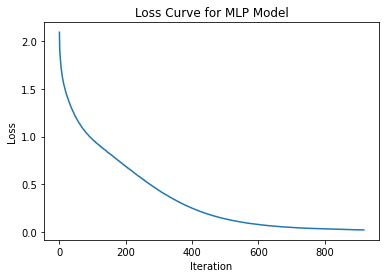

In [250]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

**Loss is indeed converging, and it appears to be a good learning rate - we want to avoid too high a learning rate since the model will bias data towards the last batches passed through it, and avoid too slow a learning rate because our model will take too long to converge.** Because of its perfect performance on the training data and poor performance on test data, we at this point suspect our model has too high a variance: It's learning to fit its weights so precisely to the training data to score well on it that its performance doesn't extend past that training data. If we had seen poor performance on both training and test sets, we would suspect our model to have a high bias. 

**To solve high variance, wherein our model is overfitting to noise present in the training data, we can decrease the number of input features and/or increase the size of the training set** so our model has more data to learn on and can generalize better to data it has not seen. **We can also use data regularization, using data augmentation techniques such as the addition of random noise to the audio samples.** Data regularization is different from weight regularization, but they work towards the same purpose of reducing overfitting.

**To solve high bias, wherein our model is underfitting to the data, we could increase the number of input features** so that it can learn a better fit to the underlying data.

**High variance makes the model's predictions inconsistent**, while **high bias makes them inaccurate** and vice versa, respectively. Ultimately, we aim to make a model that is both accurate and consistent: low variance and low bias with good performance. There is almost always a trade-off between the two.

### The Confusion Matrix
A confusion matrix describes the performance of a classification model on test data. The axes of the matrix are labelled with all possible classes, in our case emotions - **the vertical axis represents predicted classes while the horizontal axis represents the ground truth. The intersection of emotions on the matrix diagonal are correctly predicted labels.** All off-diagonal elements are incorrect predictions. We are literally checking to see where our model is confused, i.e. making incorrect predictions:

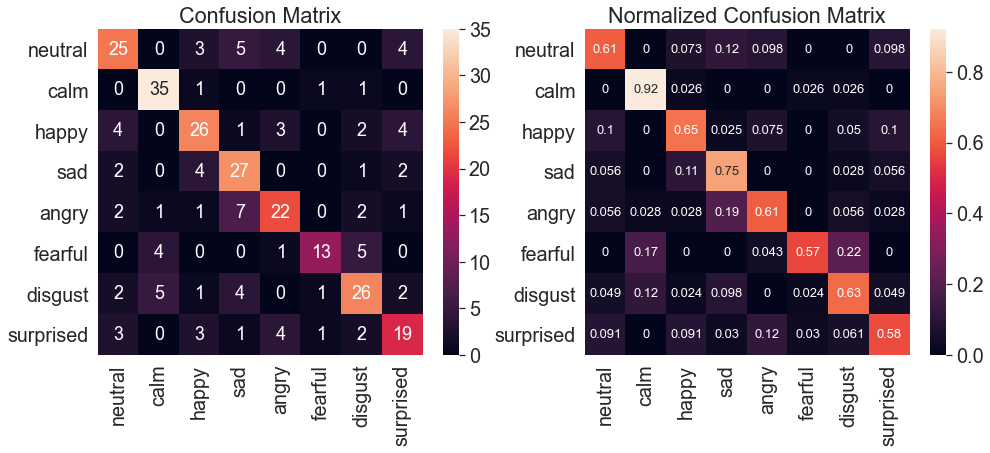

In [295]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set 
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true')

# set labels for matrix axes from emotions
emotion_list =['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
emotion_name = [emotion for emotion in emotion_list]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

The sum of elements in the left matrix is size of our test set, which is the length of y_test. That should be 0.2*1440 = 288. The matrix on the right shows each element as a percentage of samples in that class. Each row adds up to 100%, i.e. each row represents all samples of a particular emotion. 

**We can tell the model is most accurate at predicting 'calm', and least accurate at predicting 'fearful' - the latter perhaps because 'fearful' is confused for 'calm' and 'disgust'. This model also struggles particularly with the 'neutral' class as it is confused for a number of unrelated emotions.** Based on this we might look into our features to see where they are not distinct enough between confusing classes and whether we can rethink our feature engineering.

### Precision, Recall, F-Score
The confusion matrix is an intuitive measure of the precision and recall of our model w.r.t. each class. **Precision is a measure of how many positive predictions are true positives, and recall is a measure of how many positives we actually predicted from all positive samples in the dataset: Lower precision means we have more false positives, while lower recall means we have more false negatives.** For this dataset, precision of each emotion is how often we correctly predict it  and recall is how many of that emotion we predicted out of all samples with that emotion in the dataset.

**Some tasks are more concerned with maximizing precision - minimizing false positives - such as predicting whether a prisoner is likely to reoffend if paroled.** It is [catastrophic](https://www.technologyreview.com/2019/01/21/137783/algorithms-criminal-justice-ai/) to deny an inmate parole due to a false positive. 

**Some tasks are more concerned with maximizing recall - minimizing false negatives - such as predicting cancer risk from biomarkers.** It is better to inconvenience 10 people with a false positive test so we can catch the 1 true positive who would otherwise have been a false negative, rather than skip the 11 tests altogether (with 10 true negatives and 1 false negative).

**The [F-score](https://en.wikipedia.org/wiki/F1_score) is a weighted average of precision and recall when we are equally concerned with both metrics.**

**We can also make an [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#:~:text=A%20receiver%20operating%20characteristic%20curve,why%20it%20is%20so%20named.) by plotting True Positive vs False Positive Rate to visualize their trade-off and make considerations for further tuning.** However, ROC curves are usually plotted for binary classification; doing so for 

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  67.014%
Test Set Precision score =  67.779%
Test Set Recall score =  66.463%
Test Set F-score score =  66.6%


**Pretty balanced across the board - about the same false positive rate and false negative rate.** 

### K-Fold Cross-Validation
To highlight the importance of proper model validation and get a better idea of our model's performance,
we're going to use K-Fold Cross-Validation (K-Fold CV). We split our training dataset into _K_ unique validation sets (_K_ sets/folds) - the train/validation split being determined by _K_ where each _validation set = (100/K)%_ of the entire dataset, the training set being composed of the remaining _K-1_ validation sets. The term cross-validation refers to validating the model on multiple validation sets.

The terminology here may be somewhat confusing, because we usually **split our 80% _training_ set into a _training_ and _validation_ set at each iteration of K-Fold CV.** We reserve the actual _test_ set - the one we made originally with an 80/20 split of the entire dataset - for checking our model's performance _after_ we have tuned its hyperparameters.

In this way, K-Fold CV will train and score _K_ different versions of our classifier.
Note that while training sets overlap (unless otherwise defined, e.g. sklearn's GroupKFold), validation sets never overlap.
We'll use 10-fold CV, with _K=10_ being a choice giving average scores of models with fairly low bias and moderate variance due in part to the resulting 90/10 train/validation ratio. 

**K-Fold CV trains our model on _K=10_ different, overlapping training folds and check its performance against _K=10_ validation folds.**

Smaller datasets would theoretically be better scored with **higher _K_,** meaning we will have a larger portion of our dataset in training sets and a greater overlap of training samples between folds - this way we better represent a small dataset, have more training data, and hopefully provide a **better estimate of the model's true generalization error**, though at the cost of **higher variance because the _K_ estimates of our model's performance are correlated** (though there are exceptions). In the extreme case, and for computationally inexpensive models, **leave-one-out K-Fold CV (LOOCV)** can be used to construct training folds consisting of all samples-1, and 1 sample with in the validation fold; _each training fold differs by just 1 sample_ and this method provides adequate training data for each model validation on smaller training datasets. 

Sine we're training a classifier, we use **StratifiedKFold which preserves the percentage of samples in each class** (emotion) for each fold. Although we have a balanced dataset, Stratified K-Fold CV is especially important when classifying an imbalanced dataset. We also set shuffle=True to shuffle the order of sample classes in each fold to match the default behaviour of sklearn's train_test_split so we can accurately compare that to the K-Fold CV score.

Choose _K_ for our K-Fold CV and train the MLP classifier on each set of train/validation folds:

In [156]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10, 
    random_state=69, 
    shuffle=True
)

scores = []
for train_indices, test_indices in kfold.split(X_train, y_train):
    # fit model to training fold
    model.fit(X_train[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train[test_indices], y_train[test_indices]))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
48.50%
50.21%
47.53%
44.73%
49.68%
49.03%
51.83%
42.15%
49.03%
50.97%
Mean score of KFold CV for MLP: 48.37% ± 2.78%


Indeed, quite a bit worse, but a more accurate evaluation of this model. **Because we get considerably worse performance fitting our model on random subsets of our training data, we could surmise that our model's performance is inflated by overfitting** when we train and test it just once on a regular 80/20 split.

Although K-Fold CV is computationally expensive, we're getting a lot more insight out of our data and that's a serious advantage when we have very few training samples. Tuning a model to just one validation set, such as in a 60/20/20 split may provide artifically inflated performance metrics which will disappoint when the model is applied to real-world data. 

Let's dig a little deeper.

### The Validation Curve: Further Tuning of Hyperparameters

With a validation curve, we can further check our model for overfitting dependedent on hyperparameters, and which value of what hyperparameter may be contributing to overfitting by specifying a **range of parameters against which the validation curve will cross-validate the model.** We are looking to see if our model is overfitting (high variance) or underfitting (high bias) - or whether we have achieved a suitable trade-off between variance and bias. Again, our model is overfitting because of its excellent training performance and poor performance in cross-validation. **Increasing the regularization parameter alpha encourages the weights of the MLP to be smaller and reduces our model's ability to overfit its weights to the training data,** so we'll see if we can make progress there. We're going to construct two validation curves to check whether the hyperparameters alpha (L2 penalty) or epsilon (numerical stability in adam) could be better. 

The validation curve is sort of a **grid search with one parameter**, and so we don't expect that we can tune our hyperparameters any better based on what it tells us. We could have actually told grid search to return _both_ its CV and training scores and plotted them from there to understand how each hyperparameter influences our model's predictions - but computing training score for the grid is pretty computationally expensive and not really necessary.

Sklearn's validation curve implements Stratified K-Fold CV to score the model for multiclass problems, so we'll specify _K_ = 10. 

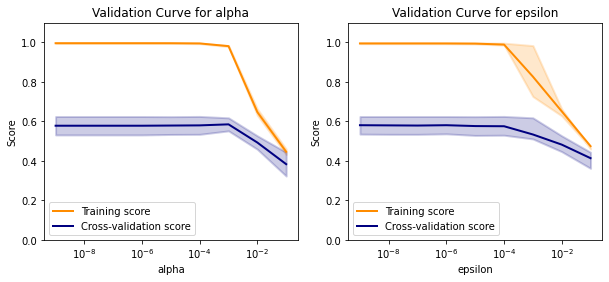

In [246]:
## import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Make sure we're using our scaled features and not other features in memory (it's a big notebook)
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    emotions, 
    test_size=0.2, 
    random_state=69
)
######## alpha ############
# Define model without alpha
model = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    # no alpha
    epsilon=1e-08, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)
# Build validation curve for 'alpha' hyperparameter
param_range = np.logspace(-8, 0, 9) # should encompass relevant values for alpha
train_scores, test_scores = validation_curve(
    model,
    X=X_train, 
    y=y_train, 
    param_name="alpha", 
    param_range=param_range,
    scoring="accuracy",
    cv=10,
    n_jobs=4
)
# Get errors for alpha validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
param_range = np.logspace(-9, -1, 9)

####### epsilon #############
# Define model without epsilon
model = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.001, 
    # no epsilon
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)

# Build validation curve for 'epsilon' hypermarameter
train_scores2, test_scores2 = validation_curve(
    model,
    X=X_train, 
    y=y_train, 
    param_name="epsilon", 
    param_range=param_range,
    scoring="accuracy",
    cv=10,
    n_jobs=4
)
# Get errors for epsilon validation curve
train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)


########### alpha plot ##########
# Plot validation curve for alpha
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Validation Curve for alpha")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
linewidth = 2
# Plot alpha train scores
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=linewidth)
# Plot error window for alpha train scores
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=linewidth)
# Plot alpha test scores
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=linewidth)
# Plot error window for alpha test scores
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=linewidth)
plt.legend(loc="best")

########## epsilon plot ##########
# Plot validation curve for epsilon
plt.subplot(1,2,2)
plt.subplots_adjust(hspace=0.5)
plt.title("Validation Curve for epsilon")
plt.xlabel("epsilon")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
# Plot epsilon train scores
plt.semilogx(param_range, train_scores_mean2, label="Training score",
             color="darkorange", lw=linewidth)
# Plot error window for epsilon train scores
plt.fill_between(param_range, train_scores_mean2 - train_scores_std2,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=linewidth)
# Plot epsilon test scores
plt.semilogx(param_range, test_scores_mean2, label="Cross-validation score",
             color="navy", lw=linewidth)
# Plot error window for epsilon test scores
plt.fill_between(param_range, test_scores_mean2 - test_scores_std2,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=linewidth)
plt.legend(loc="best")
plt.show()

Nope - as expected, little to learn here because Grid Search did well for us. Our hyperparameters are just fine where they are and in fact don't make much of a difference within a reasonable range. However, the large **gap between the training score and CV score is a clear visualization of the high variance of this model**. If the validation curve was more telling we would be looking out for where the training and CV score curves are closest.

Since deep learning methods notoriously work better with large datasets, let's check if the size of our dataset might be the problem.

### The Learning Curve: Determining Optimal Training Set Size

We can use a learning curve to compare the performance of our model if we had trained it on smaller subsets of our training dataset, and thus get an idea of whether we might expect a performance increase by using more training data, or much less likely that we don't need as much data. 

We specify variable sizes of training sets to use for the learning curve to make one model for each size. Remember that since we're using 0.8\*1440 = 1152 samples in our training set, that is the upper bound that the learning curve can check for us. Like the validation curve, sklearn's learning curve implements Stratified K-Fold CV to evaluate multiclass classification models, so again we specify _K = 10_.


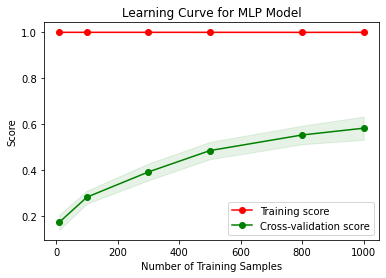

In [247]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, 
    X=X_train, 
    y=y_train, 
    cv=10, 
    shuffle=True,
    random_state=69,
    n_jobs=4, 
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples  
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

One thing the learning curve tells us is that the size of the dataset isn't our biggest issue - our **accuracy is plateauing and wouldn't seriously benefit from a larger training set** - maybe 5% at most with a gigantic dataset. Again, the gap between the training score curve and cross-validation score curve shows us that the model has an extremely high variance and - it scores perfectly on training data but poorly in cross-validation because it is seriously overfit - the model does not generalize well at all on test data. 

It has become clear that an MLP network may not be the best choice of model for this task - it seems to not have the complexity we would need to properly discriminate the differences between our features w.r.t. emotion. It appears at this point that we would need a considerably more sophisticated deep neural net to get better performance on this dataset.

## Conclusion

The MLPClassifier is powerful in that it achieves appreciable performance with relatively little effort invested in exploratory analysis, hyperparameter optimization, and model architechture; especially taking advantage of grid search, and much more so when we know how to tune each hyperparameter individually.

We're going to have to explore more complicated deep learning methods to get real performance on this dataset. **Long-Short-Term-Memory Recurrent Neural Networks (LSTM RNNs) and Convolutional Neural Networks (CNNs) are excellent DNN candidates for audio data classification: LSTM RNNs because of their excellent ability to interpret sequential data such as the audio waveform represented as a time series; CNNs because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognizing and discriminating between distinct patterns.** 


If you got this far, I sincerely appreciate your taking the time to do so. Feel free to drop me a line at ilzenkov@gmail.com with any feedback you may have. 